In [1]:
import featuretools as ft
import featuretools.variable_types as vtypes
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier as GBM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import shap
import matplotlib.pyplot as plt
## https://github.com/ag2816/TitanicKaggle/blob/master/Titanic_FeatureTools.ipynb
#from sklearn_pandas import DataFrameMapper, CategoricalImputer
data = pd.read_csv("./../Data/creditcard.csv")
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [2]:
Y = data.pop("default payment next month")
train_X , test_X ,  y_train, y_test = train_test_split(data , Y ,
                                    test_size=0.3 ,
                                    stratify = Y)
train_X.reset_index(drop=True , inplace = True)
test_X.reset_index(drop=True , inplace = True)

In [3]:
y_train.value_counts()

0    13041
1     3758
Name: default payment next month, dtype: int64

In [4]:
y_test.value_counts()

0    5589
1    1611
Name: default payment next month, dtype: int64

In [5]:
train_X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,19656,150000,2,1,2,33,0,0,0,0,...,6177,7215,7644,8367,2000,1262,1300,700,1000,950
1,3381,20000,2,3,2,23,-1,-1,-1,0,...,19325,19311,18430,400,1165,19325,386,369,400,5125
2,4407,20000,1,2,2,39,0,0,0,0,...,19979,20107,19472,19719,1334,1302,694,707,835,772
3,13001,90000,2,3,1,45,1,2,0,0,...,76823,47008,32358,33318,0,3365,2051,1200,1500,1500
4,3114,220000,2,1,1,44,-1,0,0,0,...,216062,209288,202578,195567,7611,7484,7109,6969,6661,6426


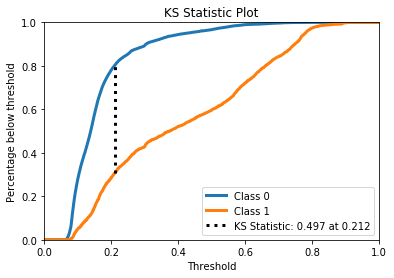

[[12602   439]
 [ 2242  1516]]
[[5316  273]
 [1028  583]]


In [6]:
rf_raw_= RandomForestClassifier(max_depth=8 ,max_features="sqrt" , n_estimators=500)
rf_raw_.fit(train_X.drop(["ID"],axis = 1), y_train)


train_prob =  rf_raw_.predict_proba(train_X.drop(["ID"],axis = 1))
skplt.metrics.plot_ks_statistic(y_train.values,train_prob)
plt.show()
train_pred =  rf_raw_.predict(train_X.drop(["ID"],axis = 1))
print(confusion_matrix(y_train , train_pred ))
test_pred =  rf_raw_.predict(test_X.drop(["ID"],axis = 1))
print(confusion_matrix(y_test,test_pred))

In [7]:
variable_types = { 'ID': vtypes.Categorical,
                  'SEX': vtypes.Categorical,
                  'MARRIAGE': vtypes.Categorical,
                  'EDUCATION': vtypes.Categorical,
                 }
es = ft.EntitySet(id = 'CREDIT')
es.entity_from_dataframe(entity_id = 'CREDIT', 
                         dataframe = train_X, 
                         index = 'ID', 
                         variable_types=variable_types)

Entityset: CREDIT
  Entities:
    CREDIT [Rows: 16799, Columns: 24]
  Relationships:
    No relationships

In [8]:
help(es.normalize_entity)

Help on method normalize_entity in module featuretools.entityset.entityset:

normalize_entity(base_entity_id, new_entity_id, index, additional_variables=None, copy_variables=None, make_time_index=None, make_secondary_time_index=None, new_entity_time_index=None, new_entity_secondary_time_index=None) method of featuretools.entityset.entityset.EntitySet instance
    Create a new entity and relationship from unique values of an existing variable.
    
    Args:
        base_entity_id (str) : Entity id from which to split.
    
        new_entity_id (str): Id of the new entity.
    
        index (str): Variable in old entity
            that will become index of new entity. Relationship
            will be created across this variable.
    
        additional_variables (list[str]):
            List of variable ids to remove from
            base_entity and move to new entity.
    
        copy_variables (list[str]): List of
            variable ids to copy from old entity
            and m

In [9]:
# agg_primitives=[
#         'std', 'min', 'max', 'mean', 
#         'percent_true', 'last', 'count', 
#         'trend', 'n_most_common', 'time_since_last',        
#         'avg_time_between'
# ]
# #         'years', 'month', 'weekday', 
# trans_primitives=[
# 'percentile', 
#         'isin', 'cum_mean', 'subtract', 'divide',
#         'time_since_previous', 'latitude', 'longitude'
# ]
# # I'll go over this below
# where_primitives = ['std', 'min', 'max', 'mean', 'count']

# from featuretools.primitives import make_trans_primitive
# from featuretools.variable_types import Numeric
# # Create two new functions for our two new primitives
# def Log(column):
#     return np.log(column)
# def Square_Root(column):
#     return np.sqrt(column)
# # Create the primitives
# log_prim = make_trans_primitive(
#     function=Log, input_types=[Numeric], return_type=Numeric)
# square_root_prim = make_trans_primitive(
#     function=Square_Root, input_types=[Numeric], return_type=Numeric)

# trans_primitives.append(log_prim)
# trans_primitives.append(square_root_prim)
# print(trans_primitives)

In [10]:
es = es.normalize_entity(base_entity_id='CREDIT', 
                         new_entity_id='EDUCATION',
                         index='EDUCATION',
                        )
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                       target_entity = 'CREDIT', 
                                       max_depth = 2, 
                                       verbose = 3, 
                                       n_jobs = 1,
                                       ignore_variables={'CREDIT':['ID']}
                                      )

Built 147 features
Elapsed: 00:01 | Progress: 100%|██████████


In [11]:
feature_matrix_enc, features_enc =\
ft.encode_features(feature_matrix, feature_names, include_unknown=False)

In [12]:
train_X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,19656,150000,2,1,2,33,0,0,0,0,...,6177,7215,7644,8367,2000,1262,1300,700,1000,950
1,3381,20000,2,3,2,23,-1,-1,-1,0,...,19325,19311,18430,400,1165,19325,386,369,400,5125
2,4407,20000,1,2,2,39,0,0,0,0,...,19979,20107,19472,19719,1334,1302,694,707,835,772
3,13001,90000,2,3,1,45,1,2,0,0,...,76823,47008,32358,33318,0,3365,2051,1200,1500,1500
4,3114,220000,2,1,1,44,-1,0,0,0,...,216062,209288,202578,195567,7611,7484,7109,6969,6661,6426


In [13]:
X_train = feature_matrix_enc.copy()
X_train.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION.MEAN(CREDIT.PAY_AMT5),EDUCATION.MEAN(CREDIT.BILL_AMT4),EDUCATION.MEAN(CREDIT.PAY_2),EDUCATION.MEAN(CREDIT.PAY_AMT1),EDUCATION.MEAN(CREDIT.BILL_AMT1),EDUCATION.NUM_UNIQUE(CREDIT.SEX),EDUCATION.NUM_UNIQUE(CREDIT.MARRIAGE),EDUCATION.MODE(CREDIT.SEX) = 2,EDUCATION.MODE(CREDIT.MARRIAGE) = 2,EDUCATION.MODE(CREDIT.MARRIAGE) = 1
ID,,,,,,,,,,,,,,,,,,,,,
19656,150000,33,0,0,0,0,0,0,11529,6745,...,5680.868065,42286.852503,-0.426590,6704.816813,48299.661367,2,4,1,1,0
3381,20000,23,-1,-1,-1,0,0,-1,17432,1165,...,3577.694662,38812.702128,0.079134,4616.069802,47897.519597,2,4,1,0,1
4407,20000,39,0,0,0,0,0,0,19592,19401,...,4487.554844,43881.337354,0.034175,5135.425556,53375.574067,2,4,1,1,0
13001,90000,45,1,2,0,0,0,0,83760,80136,...,3577.694662,38812.702128,0.079134,4616.069802,47897.519597,2,4,1,0,1
3114,220000,44,-1,0,0,0,0,0,208858,212640,...,5680.868065,42286.852503,-0.426590,6704.816813,48299.661367,2,4,1,1,0


In [16]:
print(X_train.columns.tolist())

['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX = 2', 'SEX = 1', 'MARRIAGE = 2', 'MARRIAGE = 1', 'MARRIAGE = 3', 'MARRIAGE = 0', 'EDUCATION = 2', 'EDUCATION = 1', 'EDUCATION = 3', 'EDUCATION = 5', 'EDUCATION = 4', 'EDUCATION = 6', 'EDUCATION = 0', 'EDUCATION.SUM(CREDIT.PAY_0)', 'EDUCATION.SUM(CREDIT.LIMIT_BAL)', 'EDUCATION.SUM(CREDIT.BILL_AMT6)', 'EDUCATION.SUM(CREDIT.PAY_5)', 'EDUCATION.SUM(CREDIT.BILL_AMT3)', 'EDUCATION.SUM(CREDIT.PAY_AMT2)', 'EDUCATION.SUM(CREDIT.PAY_AMT6)', 'EDUCATION.SUM(CREDIT.BILL_AMT5)', 'EDUCATION.SUM(CREDIT.PAY_AMT4)', 'EDUCATION.SUM(CREDIT.PAY_3)', 'EDUCATION.SUM(CREDIT.AGE)', 'EDUCATION.SUM(CREDIT.PAY_4)', 'EDUCATION.SUM(CREDIT.PAY_AMT3)', 'EDUCATION.SUM(CREDIT.BILL_AMT2)', 'EDUCATION.SUM(CREDIT.PAY_6)', 'EDUCATION.SUM(CREDIT.PAY_AMT5)', 'EDUCATION.SUM(CREDIT.BILL_AMT4)', 'EDUCA

In [17]:
es_tst = ft.EntitySet(id = 'Credit_TEST')
es_tst.entity_from_dataframe(entity_id = 'CREDIT', 
                             dataframe = test_X,
                             index = 'ID')
es_tst = es_tst.normalize_entity(base_entity_id='CREDIT',
                                 new_entity_id='EDUCATION',
                                 index='EDUCATION',
                                )
feature_matrix_tst = ft.calculate_feature_matrix(features=features_enc, entityset=es_tst)

In [18]:
test_X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,15964,70000,2,2,1,35,0,0,0,0,...,68263,68927,69176,70592,3001,3052,3348,2617,2840,2674
1,22354,80000,2,2,1,30,0,0,0,0,...,13207,13997,10914,10685,1600,1700,1400,200,1000,0
2,22236,180000,2,1,2,29,-1,-1,-1,-1,...,906,6101,50372,1203,222,908,6101,48251,1207,4545
3,21737,30000,2,3,1,21,0,0,0,0,...,25289,25971,25350,5082,2091,1600,1600,301,102,40
4,2470,170000,2,2,2,26,0,0,0,0,...,134502,122186,122506,117121,5113,4514,4376,4432,4142,3455


In [19]:
X_test = feature_matrix_tst.copy()
X_test.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,EDUCATION.MEAN(CREDIT.PAY_AMT5),EDUCATION.MEAN(CREDIT.BILL_AMT4),EDUCATION.MEAN(CREDIT.PAY_2),EDUCATION.MEAN(CREDIT.PAY_AMT1),EDUCATION.MEAN(CREDIT.BILL_AMT1),EDUCATION.NUM_UNIQUE(CREDIT.SEX),EDUCATION.NUM_UNIQUE(CREDIT.MARRIAGE),EDUCATION.MODE(CREDIT.SEX) = 2,EDUCATION.MODE(CREDIT.MARRIAGE) = 2,EDUCATION.MODE(CREDIT.MARRIAGE) = 1
ID,,,,,,,,,,,,,,,,,,,,,
15964,70000,35,0,0,0,0,0,0,68445,67371,...,4375.210820,43103.634519,0.034402,4798.103499,51748.452514,2,4,True,True,False
22354,80000,30,0,0,0,0,0,0,22113,21507,...,4375.210820,43103.634519,0.034402,4798.103499,51748.452514,2,4,True,True,False
22236,180000,29,-1,-1,-1,-1,0,-1,3900,222,...,5827.930040,42471.496838,-0.356917,6373.213043,48790.905138,2,4,True,True,False
21737,30000,21,0,0,0,0,2,0,28884,25277,...,3666.146029,35929.842015,0.015371,4644.427839,44245.040991,2,4,True,False,True
2470,170000,26,0,0,0,0,0,0,141476,143850,...,4375.210820,43103.634519,0.034402,4798.103499,51748.452514,2,4,True,True,False


In [20]:
threshold = 0.8
corr_matrix  = X_train.corr().abs() 

In [21]:
import numpy as np
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]

In [22]:
X_train_flt = X_train.drop(columns = collinear_features)
X_test_flt = X_test.drop(columns = collinear_features)
X_train_flt.shape, X_test_flt.shape

((16799, 40), (7200, 40))

In [23]:
X_train_flt.columns.tolist()

['LIMIT_BAL',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'BILL_AMT1',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'SEX = 2',
 'MARRIAGE = 2',
 'MARRIAGE = 3',
 'MARRIAGE = 0',
 'EDUCATION = 2',
 'EDUCATION = 1',
 'EDUCATION = 3',
 'EDUCATION = 5',
 'EDUCATION = 4',
 'EDUCATION = 6',
 'EDUCATION = 0',
 'EDUCATION.MAX(CREDIT.LIMIT_BAL)',
 'EDUCATION.MIN(CREDIT.PAY_0)',
 'EDUCATION.MIN(CREDIT.LIMIT_BAL)',
 'EDUCATION.MIN(CREDIT.PAY_5)',
 'EDUCATION.MIN(CREDIT.PAY_AMT2)',
 'EDUCATION.MIN(CREDIT.PAY_AMT6)',
 'EDUCATION.MIN(CREDIT.PAY_AMT4)',
 'EDUCATION.MIN(CREDIT.PAY_3)',
 'EDUCATION.MIN(CREDIT.PAY_4)',
 'EDUCATION.MIN(CREDIT.PAY_AMT3)',
 'EDUCATION.MIN(CREDIT.PAY_6)',
 'EDUCATION.MIN(CREDIT.PAY_AMT5)',
 'EDUCATION.MIN(CREDIT.PAY_2)',
 'EDUCATION.MIN(CREDIT.PAY_AMT1)',
 'EDUCATION.NUM_UNIQUE(CREDIT.SEX)',
 'EDUCATION.MODE(CREDIT.SEX) = 2']

In [24]:
rf = RandomForestClassifier(max_depth=8 ,max_features="sqrt" , n_estimators=500)
rf.fit(X_train , y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

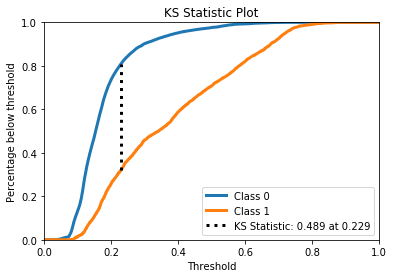

In [25]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
train_prob =  rf.predict_proba(X_train)
skplt.metrics.plot_ks_statistic(y_train.values,train_prob)
plt.show()

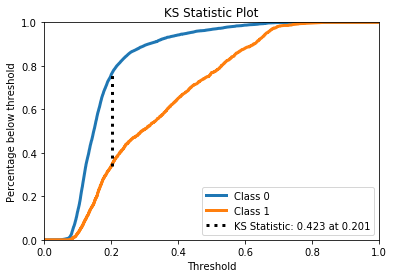

In [26]:
test_prob =  rf.predict_proba(X_test)
skplt.metrics.plot_ks_statistic(y_test.values,test_prob)
plt.show()

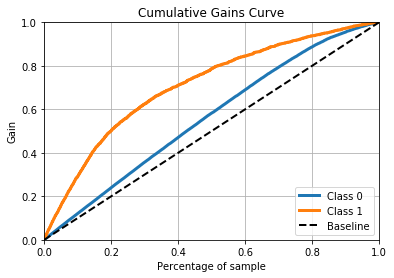

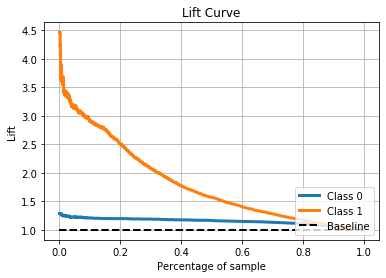

In [27]:
skplt.metrics.plot_cumulative_gain(y_test.values , test_prob)
plt.show()
skplt.metrics.plot_lift_curve(y_test.values , test_prob)
plt.show()

In [28]:
confusion_matrix(y_train , rf.predict(X_train))

array([[12729,   312],
       [ 2658,  1100]])

In [29]:
confusion_matrix(y_test,rf.predict(X_test))

array([[5408,  181],
       [1238,  373]])

In [30]:
shap_values = shap.TreeExplainer(rf).shap_values(X_test)

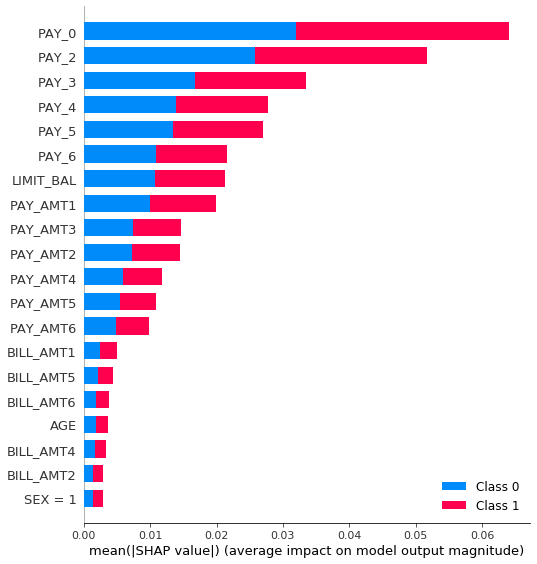

In [31]:
shap.summary_plot(shap_values, X_test , plot_type="bar")

In [32]:
# shap_values = shap.TreeExplainer(rf).shap_values(X_train)
# shap.summary_plot(shap_values, X_train , plot_type="bar")

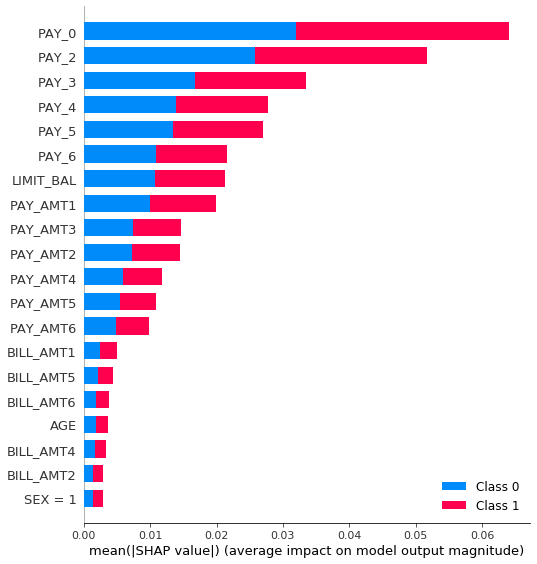

In [33]:
shap.summary_plot(shap_values, X_test)

In [36]:
shap_values.

[array([[-1.27446241e-02,  9.74025182e-04,  2.15585570e-02, ...,
          0.00000000e+00,  1.92635316e-05,  4.02968046e-06],
        [-5.30094034e-03,  1.38939444e-03,  2.10481825e-02, ...,
          0.00000000e+00,  2.54090704e-05,  1.16678320e-05],
        [ 8.45336570e-03,  1.46205378e-03,  1.64295846e-02, ...,
          0.00000000e+00,  9.29447282e-06,  1.86744269e-05],
        ...,
        [ 6.36270622e-03,  1.76503628e-03,  1.77226578e-02, ...,
          0.00000000e+00, -1.13730348e-05,  1.23839480e-05],
        [-1.11445765e-02,  1.04183213e-03,  2.12796101e-02, ...,
          0.00000000e+00,  1.74402678e-05,  3.19598780e-06],
        [-1.36235517e-02, -5.30776903e-05,  2.17826090e-02, ...,
          0.00000000e+00,  1.39972243e-05,  3.09269280e-06]]),
 array([[ 1.27446239e-02, -9.74025281e-04, -2.15585572e-02, ...,
          0.00000000e+00, -1.92635352e-05, -4.02968034e-06],
        [ 5.30094018e-03, -1.38939448e-03, -2.10481827e-02, ...,
          0.00000000e+00, -2.54090715e-05, -1.16678312e-05],
        [-8.45336569e-03, -1.46205378e-03, -1.64295848e-02, ...,
          0.00000000e+00, -9.29448239e-06, -1.86744267e-05],
        ...,
        [-6.36270648e-03, -1.76503633e-03, -1.77226579e-02, ...,
          0.00000000e+00,  1.13730433e-05, -1.23839477e-05],
        [ 1.11445762e-02, -1.04183214e-03, -2.12796103e-02, ...,
          0.00000000e+00, -1.74402714e-05, -3.19598762e-06],
        [ 1.36235516e-02,  5.30775658e-05, -2.17826091e-02, ...,
          0.00000000e+00, -1.39972262e-05, -3.09269269e-06]])]

Could not find feature named: default payment next month.SKEW(CREDIT.PAY_AMT2)


AssertionError: 'shap_values' and 'features' values must have the same number of rows!

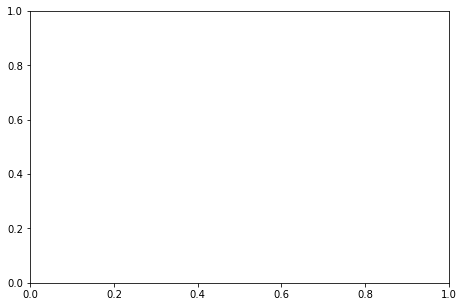

In [32]:
target = 1
shap.dependence_plot("default payment next month.SKEW(CREDIT.PAY_AMT2)", 
                     shap_values[target], 
                     X_train)

In [ ]:
def shap_plot(model, j , X, target):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(X)
    p = shap.force_plot(explainerModel.expected_value[target], 
                        shap_values_Model[target][j], X.iloc[[j]])
    return(p)

def shap_decision_plot(model, j , X, target):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(X)
    p = shap.decision_plot(explainerModel.expected_value[target],
                           shap_values_Model[target][j], X.iloc[j])
    return(p)

def shap_embedding_plot(model, j , X, target, name):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(X)
    p = shap.embedding_plot(j ,
                            shap_values_Model[target],
                            name)
    return(p)

In [ ]:
shap.initjs()
shap_plot(rf, 10 , X_train,0)

In [ ]:
shap_decision_plot(rf, np.arange(500), X_train, 1)

In [ ]:
vars = X_train.columns.tolist()

In [ ]:
shap_embedding_plot(rf,2  , X_train,0, vars[0])